## Análise exploratória das concessões de bolsas do Capes
Período de análise: abril/2005 a dezembro/2019.<br><br>


Questionamento a serem respondidos:<br>

1. Qual a evolução da quantidade de bolsas distribuídas?
2. Em qual mês, houveram mais distribuições de bolsas?
3. Para qual grande área do conhecimento foram distribuídas mais bolsas?
4. Quais grais de ensino receberam mais bolsas e quanto tempo normalmente duram?
7. Quais os principais países de destino?

### Bibliotecas

In [37]:
import basedosdados
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

### Ajustando banco de dados (bd) do projeto

In [38]:
# Criando ou, caso já exista, conectando-se ao banco de dados do projeto
con = sqlite3.connect( 'historicoBolsas.db' )

# Objeto para executar comandos e recuperar resultados do banco de dados
cur = con.cursor()

# Nome da tabela no banco de dados
nomeTabela = 'bolsas'

### Coleta de dados
Verificar existência da tabela no bd do projeto; se não ela existir, realizar consulta no Data Lake e inserir dados no bd

In [39]:
# Query para verificar se a tabela já existe no banco de dados
q = f""" SELECT name
         FROM sqlite_master
         WHERE type = 'table' AND name = '{ nomeTabela }' """

# Executando query no banco
verificacao = cur.execute( q ).fetchone()

In [40]:
# Se a tabela não existir, realizar consulta ao banco de dados
if verificacao is None:

    # Consultando tabela no Data Lake público da Base dos dados
    df = basedosdados.read_table( dataset_id         = 'br_capes_bolsas',
                                  table_id           = 'mobilidade_internacional',
                                  billing_project_id = 'portfolio-367913' )
    
    # Armazenando dados da consulta no banco de dados do projeto
    df.to_sql(  nomeTabela, con = con, index = False )

Tendo coletado os dados e armazenando no banco, próximo passo é consultar a informação

In [41]:
# Query para coletar tabela que fornecerá base para respostas às questões do projeto
q = f""" SELECT CAST( ano_inicial AS TEXT ) || '-' || CAST( mes_inicial AS TEXT ) || '-01' AS periodo_inicial,
                CAST( ano_final   AS TEXT ) || '-' || CAST( mes_final   AS TEXT ) || '-01' AS periodo_final,
                id_processo_concessao,
                pais_destino,
                area_avaliacao,
                area_conhecimento,
                grande_area_conhecimento,
                nivel_ensino,
                instituicao_ensino_principal,
                instituicao_ensino
         FROM { nomeTabela } """

# Consultando dados no bd do projeto
df = pd.read_sql( q, con, parse_dates = [ 'periodo_inicial', 'periodo_final' ] )

### Tratando tabela

O processo de tratamento será bastante assertivo devido a análise do schema da tabela original<br>
na busca da escolha das colunas que fornecerão os dados desejados.

Para verificar todo o schema da tabela original, acessar aquivo "schemaDataSource.xlsx".

Algumas colunas que possivelmente possuem informações redundantes foram selecionadas<br>
propositalmente.  O objetivo é verificar a qualidade das informações e selecionar as mais adequadas.

In [42]:
# Visualizando DataFrame
df.head()

,periodo_inicial,periodo_final,id_processo_concessao,pais_destino,area_avaliacao,area_conhecimento,grande_area_conhecimento,nivel_ensino,instituicao_ensino_principal,instituicao_ensino
0,2005-04-01,2010-03-01,1898-04-3,ALEMANHA,None,None,ENGENHARIAS,DOUTORADO PLENO,TECHNISCHE UNIVERSITÄT DARMSTADT,TECHNISCHE UNIVERSITÄT DARMSTADT
1,2006-10-01,2010-09-01,3158-05-5,REINO UNIDO,None,None,CIÊNCIAS SOCIAIS APLICADAS,DOUTORADO PLENO,UNIVERSITY OF CAMBRIDGE,UNIVERSITY OF CAMBRIDGE
2,2006-10-01,2010-07-01,2520-05-2,ESTADOS UNIDOS,None,None,CIÊNCIAS SOCIAIS APLICADAS,DOUTORADO PLENO,DUKE UNIVERSITY,DUKE UNIVERSITY
3,2006-10-01,2010-07-01,4199-05-7,REINO UNIDO,None,None,CIÊNCIAS SOCIAIS APLICADAS,DOUTORADO PLENO,ROYAL COLLEGE OF ART,ROYAL COLLEGE OF ART
4,2006-10-01,2010-09-01,4047-05-2,REINO UNIDO,None,None,CIÊNCIAS SOCIAIS APLICADAS,DOUTORADO PLENO,UNIVERSITY OF BRISTOL,UNIVERSITY OF BRISTOL


In [43]:
# Quantidade de valores nulos nas colunas
df.isna().sum()

periodo_inicial                      0
periodo_final                        0
id_processo_concessao                0
pais_destino                         0
area_avaliacao                   15881
area_conhecimento                28829
grande_area_conhecimento          5239
nivel_ensino                         0
instituicao_ensino_principal    120155
instituicao_ensino                   8
dtype: int64

As colunas que possuem maior número de valores nulos também são as que<br>
possuem informações com grau de redundância; dessa forma, serão excluídas do nosso projeto.

In [44]:
# Removendo colunas 
df.drop( columns = [ 'area_avaliacao', 'area_conhecimento', 'instituicao_ensino_principal' ],
         inplace = True )

Outro ponto de obervação é que, apesar das colunas restantes possuírem maior qualidade,<br>
ainda há colunas com valores nulos. Estes valores não serão removidos, serão parte integrante da análise.

In [45]:
# Modificando todos os valores nulos
df.fillna( 'SEM REGISTRO', inplace = True )

In [46]:
# Observando DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146036 entries, 0 to 146035
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   periodo_inicial           146036 non-null  datetime64[ns]
 1   periodo_final             146036 non-null  datetime64[ns]
 2   id_processo_concessao     146036 non-null  object        
 3   pais_destino              146036 non-null  object        
 4   grande_area_conhecimento  146036 non-null  object        
 5   nivel_ensino              146036 non-null  object        
 6   instituicao_ensino        146036 non-null  object        
dtypes: datetime64[ns](2), object(5)
memory usage: 7.8+ MB


In [47]:
# Visualizando resultado
df.head()

,periodo_inicial,periodo_final,id_processo_concessao,pais_destino,grande_area_conhecimento,nivel_ensino,instituicao_ensino
0,2005-04-01,2010-03-01,1898-04-3,ALEMANHA,ENGENHARIAS,DOUTORADO PLENO,TECHNISCHE UNIVERSITÄT DARMSTADT
1,2006-10-01,2010-09-01,3158-05-5,REINO UNIDO,CIÊNCIAS SOCIAIS APLICADAS,DOUTORADO PLENO,UNIVERSITY OF CAMBRIDGE
2,2006-10-01,2010-07-01,2520-05-2,ESTADOS UNIDOS,CIÊNCIAS SOCIAIS APLICADAS,DOUTORADO PLENO,DUKE UNIVERSITY
3,2006-10-01,2010-07-01,4199-05-7,REINO UNIDO,CIÊNCIAS SOCIAIS APLICADAS,DOUTORADO PLENO,ROYAL COLLEGE OF ART
4,2006-10-01,2010-09-01,4047-05-2,REINO UNIDO,CIÊNCIAS SOCIAIS APLICADAS,DOUTORADO PLENO,UNIVERSITY OF BRISTOL


### Análises

In [48]:
# Definindo qualidade dos gráficos plotados
plt.rcParams['figure.dpi'] = 200

# Definindo tamanho da fonte do(s) gráfico(s)
plt.rcParams.update( { 'font.size': 5 } )

#### Qual a evolução da quantidade de bolsas distribuídas?

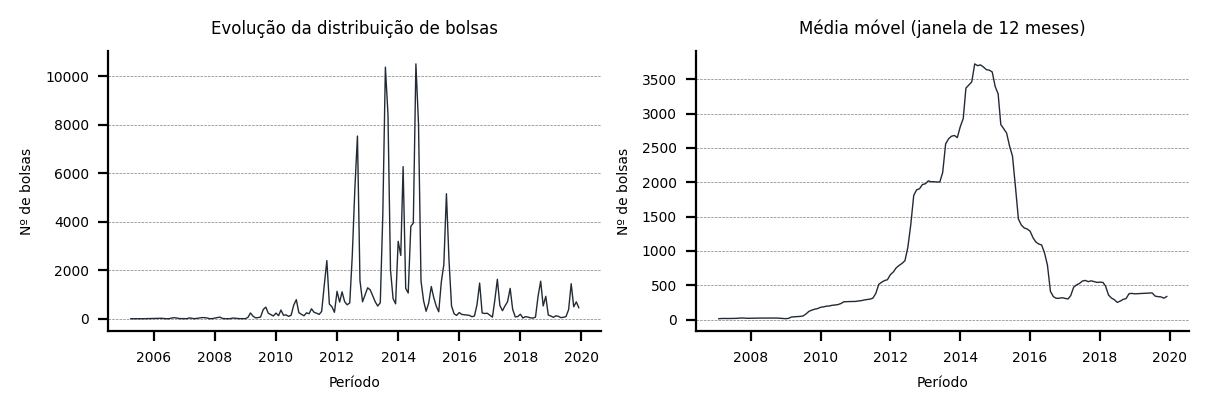

In [49]:
# Armazenando em variáveis a figura e os eixos dos gráficos; definindo tamanho da figura
fig, axs = plt.subplots( figsize = ( 6, 2 ), ncols = 2 )

# Dados ( Python series, onde o index são datas e o valores a contagem de bolsas concedidas )
evolucao = df.groupby( 'periodo_inicial' )[ 'id_processo_concessao' ].count()

# Ajustando nomes de x e y
xlabel, ylabel = 'Período', 'Nº de bolsas'

# Plotando gráficode de Evolução da quantidade de bolsas
axs[0].plot( evolucao.index, evolucao.values, color = '#222B35', linestyle = 'solid', linewidth = 0.5 )
axs[0].set_xlabel( xlabel )
axs[0].set_ylabel( ylabel )
axs[0].set_title( 'Evolução da distribuição de bolsas' )

# Plotando gráfico de Média móvel (janela de 12 meses)
axs[1].plot( evolucao.index, evolucao.rolling( 12 ).mean().values, color = '#222B35', linestyle = 'solid', linewidth = 0.5 )
axs[1].set_xlabel( xlabel )
axs[1].set_ylabel( ylabel )
axs[1].set_title( 'Média móvel (janela de 12 meses)' )

# Excluindo linha de contorno superior e direito dos eixos de plotagem
for ax in axs:
    ax.spines[ 'top'   ].set_visible( False )
    ax.spines[ 'right' ].set_visible( False )

# Definindo forma das linhas de grid dos eixos y
for ax in axs:
    ax.yaxis.grid( True, linestyle = '--', linewidth = 0.25, color = 'gray', alpha = 1 )

# Ajustando o espaçamento entre os gráficos
plt.tight_layout()

# Exibindo os gráficos
plt.show()


Podemos observa que de 2005 até meados de 2010, a quantidade de bolsas cedidas<br>
era ínfima. E entre 2012 e 2015, tivemos picos de distribuições delas, que foram rapidamente decaindo,<br>
voltando a níveis próximos aos iniciais.<br>

---
#### Em qual mês, houveram mais distribuições de bolsas?

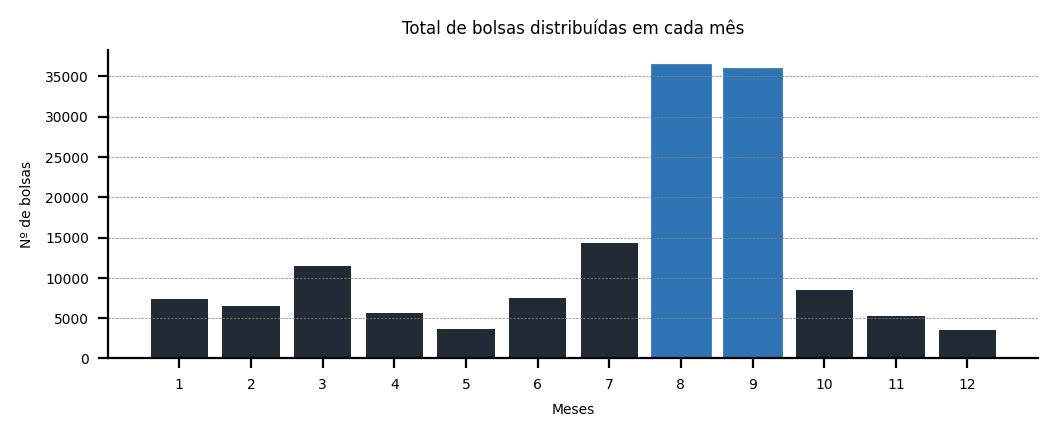

In [50]:
# Armazenando em variáveis a figura e os eixos dos gráficos; definindo tamanho da figura
fig, ax = plt.subplots( figsize = ( 6, 2 ) )

# Dados ( Python series, onde o index é o mês e os valores a contagem de bolsas concedidas )
quantidadeMes = df.groupby( df['periodo_inicial'].dt.month )[ 'id_processo_concessao' ].count()

# Ajustando nomes de x e y
xlabel, ylabel = 'Meses', 'Nº de bolsas'

# Plotando gráfico de evolução da quantidade de bolsas distribuídas por mês
ax.bar( quantidadeMes.index, quantidadeMes.values, color = '#222B35' )
ax.set_xlabel( xlabel )
ax.set_ylabel( ylabel )
ax.set_title( 'Total de bolsas distribuídas em cada mês' )

# Definindo cores padrão para as barras e destaques para os meses 8 e 9
corDestaque = '#2F75B5'

# Destacando as barras dos meses 8 e 9 com cores diferentes
mesesDestaque = [ 8, 9 ]
for i, bar in enumerate( ax.containers[0] ):
    if i + 1 in mesesDestaque:
        bar.set_color( corDestaque )

# Excluindo linha de contorno superior e direito dos eixos de plotagem
ax.spines[ 'top'   ].set_visible( False )
ax.spines[ 'right' ].set_visible( False )

# Definindo forma das linhas de grid dos eixos y
ax.yaxis.grid( True, linestyle = '--', linewidth = 0.25, color = 'gray', alpha = 1 )

# Ajustando rótulos do eixo x
ax.set_xticks( quantidadeMes.index )
ax.set_xticklabels( quantidadeMes.index )

# Exibindo os gráficos
plt.show()

Podemos observar que, disparadamente, os meses de agosto e setembro acumularam<br>
a maior quantidade de distribuições de bolsas. Enquanto os outros não chegaram a ultrapassar a barreira dos 15 mil;<br>
ou seja, ambos ou meses concederam mais que o drobro dos meses restantes.

---
#### Para qual grande área do conhecimento foram distribuídas mais bolsas?

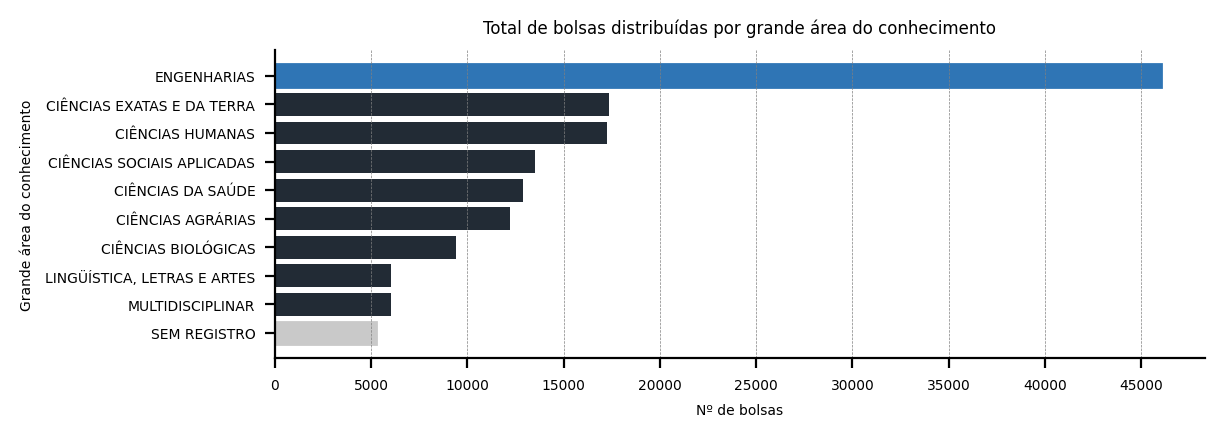

In [51]:
# Armazenando em variáveis a figura e os eixos dos gráficos; definindo tamanho da figura
fig, ax = plt.subplots( figsize = ( 6, 2 ) )

# Dados ( Python series, onde o index é a área de conhecimento e os valores a contagem de bolsas concedidas )
c = [ 'grande_area_conhecimento' ]
porArea = df.groupby( c )[ 'id_processo_concessao' ].count().sort_values()

# Ajustando nomes de x e y
xlabel, ylabel = 'Nº de bolsas', 'Grande área do conhecimento'

# Plotando gráfico de evolução da quantidade de bolsas
ax.barh( porArea.index, porArea.values, color = '#222B35' )
ax.set_xlabel( xlabel )
ax.set_ylabel( ylabel )
ax.set_title( 'Total de bolsas distribuídas por grande área do conhecimento' )

# Definindo cores padrão para as barras e destaques 1º
corSemRegistro = '#C9C9C9'
corDestaque = '#2F75B5'

nGrandesAreas = len( porArea.index.unique() )
for i, bar in enumerate( ax.containers[0] ):
    if i == 0: bar.set_color( corSemRegistro )
    elif i + 1 == nGrandesAreas: bar.set_color( corDestaque )

# Excluindo linha de contorno superior e direito dos eixos de plotagem
ax.spines[ 'top'   ].set_visible( False )
ax.spines[ 'right' ].set_visible( False )

# Definindo forma das linhas de grid dos eixos y
ax.xaxis.grid( True, linestyle = '--', linewidth = 0.25, color = 'gray', alpha = 1 )

# Ajustando intervalo dos valores no eixo x
ax.set_xticks(range(0, int(max(porArea.values)) + 1, 5000))

# Exibindo os gráficos
plt.show()

---
#### Quais grais de ensino receberam mais bolsas e quanto tempo normalmente duram?

In [52]:
# Subset necessário
ge = df[ [ 'nivel_ensino', 'periodo_inicial', 'periodo_final' ] ]

# Coluna com a diferença entre períodos
ge['diferenca_dias'] = ( ge[ 'periodo_final' ] - ge[ 'periodo_inicial' ] ).dt.days

Analisando incosistências

In [53]:
# Verificação de inconsistências na data de bolsas
incon = ge['diferenca_dias'][ ge['diferenca_dias'] <= 0 ].count()

# O valor percentual que as incosistências apresentam no todo
inconPercent = round( incon / len( ge ), 4 ) * 100

print( f'Há { incon } observações inconsistentes, onde o período final é antes ou igual ao inicial.',
       f'\nDessa forma, é necessário desconsiderá-los, o que representa cerca de { inconPercent }% do total.' )

Há 2003 observações inconsistentes, onde o período final é antes ou igual ao inicial. 
Dessa forma, é necessário desconsiderá-los, o que representa cerca de 1.37% do total.


Tratando inconsistências e analisando

In [54]:
# Subset ajustado, sem as inconsistências de período
geAjust = ge.query( 'diferenca_dias > 0' )

In [55]:
# Dados ( Python series, sendo index o nível de ensino e valores a contagem e média de bolsas distribuídas )
geAgrupada = ( geAjust.groupby( [ 'nivel_ensino' ] )[ 'diferenca_dias' ].agg( [ 'count', 'mean' ] )                       
                      
                      # Classificando contagem
                      .sort_values( by = 'count', ascending = False )
                        
                      # Criando colunas
                      .assign( mean = lambda df: round( df[ 'mean' ], 0 ),
                                percent_acum = lambda df: round( df[ 'count' ].agg( 'cumsum' ) / len( geAjust ) * 100, 2 ) )
                        
                      # Renomeando colunas
                      .rename( columns = { 'count': 'Nº de bolsas distribuídas',
                                           'mean' : 'Média de duracao da bolsa (em dias)',
                                           'percent_acum': 'Representação_percentual_acumulada' } ) )

In [56]:
# Filtrando os grais de ensino que representam até 98% do total de bolsas distibuídas
principaisGraisEnsino = geAgrupada.query( 'Representação_percentual_acumulada <= 98' )
principaisGraisEnsino

,Nº de bolsas distribuídas,Média de duracao da bolsa (em dias),Representação_percentual_acumulada
nivel_ensino,,,
GRADUAÇÃO SANDUÍCHE,85230,393.0,59.17
DOUTORADO SANDUÍCHE,33920,215.0,82.72
DOUTORADO PLENO,8644,1327.0,88.73
ESTÁGIO PÓS-DOUTORAL,6657,324.0,93.35
ESTÁGIO SÊNIOR,2886,259.0,95.35
PÓS-DOUTORADO,1519,323.0,96.41
PESQUISADOR VISITANTE ESPECIAL,1118,986.0,97.18
MESTRADO PROFISSIONAL NOS EUA,560,606.0,97.57
MESTRADO SANDUÍCHE,470,201.0,97.90


In [57]:
# Total de níveis de ensino
lenGeral = len( geAgrupada )

# Total de níves que acumularam até 98% do total
lenPrincipais = len( principaisGraisEnsino )

print( 'QUANTIDADE DE BOLSAS',
       f'\n--------------------------\nHouveram ao total {lenGeral} grais de ensino, onde {lenPrincipais} acumularam 97.90% de todas as bolsas distribuídas.',
       
       '\n\nEm especial, temos "GRADUAÇÃO SANDUÍCHE" que acumulou, sozinha, quase 60% delas e "DOUTORADO SANDUÍCHE" que',
       '\npor sua vez captou cerca de 23%; juntas representaram 82,72% do total.',
       
       '\n\nTEMPO DE DURAÇÃO',
       '\n--------------------------\nDos grais mais frequentes, aqueles que mais exigiram a permanência dos pós graduandos',
       '\nforam "DOUTORADO PLENO" (+3,5 anos), "PESQUISADOR VISITANTE ESPECIAL" (+2,5 anos), "MESTRADO PROFISSIONAL NOS EUA" (+1,5 anos).',
       '\nTodos os demais tiveram duração inferior a 1 ano e meio.' )


QUANTIDADE DE BOLSAS 
--------------------------
Houveram ao total 44 grais de ensino, onde 9 acumularam 97.90% de todas as bolsas distribuídas. 

Em especial, temos "GRADUAÇÃO SANDUÍCHE" que acumulou, sozinha, quase 60% delas e "DOUTORADO SANDUÍCHE" que 
por sua vez captou cerca de 23%; juntas representaram 82,72% do total. 

TEMPO DE DURAÇÃO 
--------------------------
Dos grais mais frequentes, aqueles que mais exigiram a permanência dos pós graduandos 
foram "DOUTORADO PLENO" (+3,5 anos), "PESQUISADOR VISITANTE ESPECIAL" (+2,5 anos), "MESTRADO PROFISSIONAL NOS EUA" (+1,5 anos). 
Todos os demais tiveram duração inferior a 1 ano e meio.


---
#### Quais os principais países de destino?

In [58]:
# Dados ( Pandas Dataframe, agrupado por País de destino e os valores a contagem de bolsas concedidas )
pais = ( df.groupby( [ 'pais_destino' ], as_index = False )[ 'id_processo_concessao' ].count()
           
           # Classificando contagem
           .sort_values( by = 'id_processo_concessao', ascending = False )
           
           # Gerando representação percentual
           .assign( percent_total = lambda dfa: round( dfa['id_processo_concessao'] / len( df ) * 100, 2 ) )
           
           # Renomeando colunas
           .rename( columns = { 'pais_destino': 'País',
                                'id_processo_concessao': 'Nº de bolsas distribuídas',
                                'percent_total': 'Representação no total %'  } )
           
           # Definindo index
           .set_index( 'País' ) )

Top 10 países de destino dos bolsistas

In [59]:
pais[0:10]

,Nº de bolsas distribuídas,Representação no total %
País,,
ESTADOS UNIDOS,34350,23.52
FRANÇA,24234,16.59
ALEMANHA,14798,10.13
PORTUGAL,11783,8.07
BRASIL,8912,6.10
ITÁLIA,8340,5.71
REINO UNIDO,7466,5.11
CANADÁ,6555,4.49
IRLANDA,5666,3.88
